In [16]:
import time
import numpy as np
import pandas as pd
from datasets import ClassLabel, Dataset, DatasetDict, concatenate_datasets
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoModel, AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from sklearn.metrics import log_loss
#from umap import UMAP

In [17]:
def plot_number_of_features(text_column):
    # this function plot a subplot compose of 2 barchart, where each barchart show the distribution of
    # token number of text feature respect to bert and pegasus token techniques

    model_bert = "nlpaueb/legal-bert-small-uncased"
    tokenizer_bert = AutoTokenizer.from_pretrained(model_bert)
    model_pegasus = "nsi319/legal-pegasus"
    tokenizer_pegasus = AutoTokenizer.from_pretrained(model_pegasus)

    # plotting sentences lenghth distribution (in terms of token)
    bert_len = [len(tokenizer_bert.encode(s)) for s in text_column]
    pagasus_len = [len(tokenizer_pegasus.encode(s)) for s in text_column]

    fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
    axes[0].hist(bert_len, bins=100, color="C0", edgecolor="C0")
    axes[0].axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1",
               label="Maximum sequence length")
    axes[0].set_title("Bert Token Length")
    axes[0].set_xlabel("Length")
    axes[0].set_ylabel("Count")
    axes[1].hist(pagasus_len, bins=100, color="C0", edgecolor="C0")
    axes[1].axvline(x=1024, ymin=0, ymax=1, linestyle="--", color="C1",
                    label="Maximum sequence length")
    axes[1].set_title("Pegasus Token Length")
    axes[1].set_xlabel("Length")
    plt.tight_layout()
    plt.show()

#Loading Dataset
df = pd.read_csv("./datasets/legal_text_classification.csv")

Token indices sequence length is longer than the specified maximum sequence length for this model (660 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/24809 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (980 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1561 > 1024). Running this sequence through the model will result in indexing errors


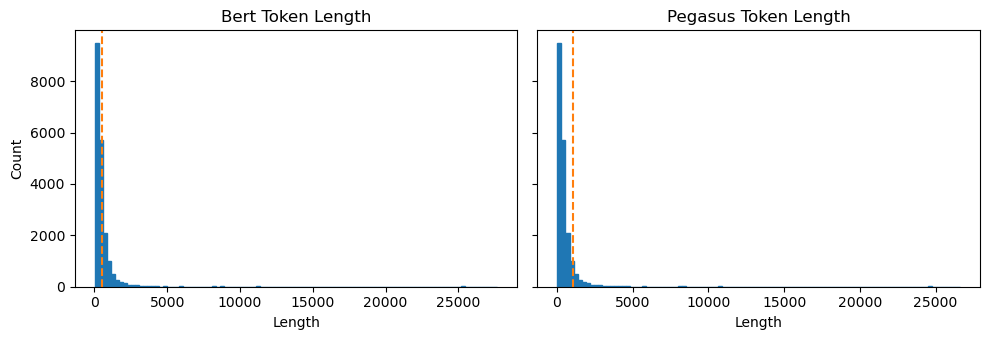

In [3]:
def preprocess_data(df):
    #adding token_lenght column
    df["lb_num_token"] = d_len
    
    #Dropping Nan values
    df = df.dropna(subset=['case_text'])

    # Dropping unused features and renaming columns
    df = df.drop(columns =['case_id', 'case_title'])
    df.rename(columns={"case_text":"text", "case_outcome":"label"}, inplace= True)

    # Get the number of unique labels
    labels_list = df["label"].unique().tolist()
    
    # Splitting Dataset
    df = Dataset.from_pandas(df)
    df = df.map(lambda example: {'text': str(example['text'])})
    train_valid = df.train_test_split(test_size= 0.2, seed= 42)
    valid_test  = train_valid["test"].train_test_split(test_size= 0.5, seed= 42)
    
    df_split = DatasetDict({
    'train': train_valid['train'],
    'valid': valid_test['train'],
    'test': valid_test['test']
    })
    
    return df_split, labels_list

# number of bert token for each sample
model_ckpt = "nlpaueb/legal-bert-small-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)  
d_len = [len(tokenizer.encode(str(s))) for s in df["case_text"]]

# preprocessing dataset
df, labels_list = preprocess_data(df)


plot_number_of_features(df["train"]["text"])

train = Dataset.from_dict(df["train"][0:9])
valid = Dataset.from_dict(df["valid"][0:9])


In [4]:
def pegasus_summary(batch_samples, model, tokenizer):
    # This function take in input a batch of samples and return the summary of each sample.
    # The summary length is set to 400 token length, because the output summary will be used as bert tokenizer input
    # LLM used: legal-pegasus
    # It will be better to call this function with model anf tokenizer already define inside the main code

    summary = ""
    # summary
    input_tokenized = tokenizer.encode(batch_samples["text"], return_tensors='pt', max_length=1024, truncation=True).to(device)
    with torch.no_grad():
        summary_ids = model.generate(input_tokenized,
                                     num_beams=9,
                                     no_repeat_ngram_size=3,
                                     length_penalty=2.0,
                                     min_length=150,
                                     max_length=400,
                                     early_stopping=True)

    summary = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids][0]
    return {"text": summary}

In [5]:
def summarizing_samples(df):
    model_ckpt_sum = "nsi319/legal-pegasus"
    tokenizer_sum = AutoTokenizer.from_pretrained(model_ckpt_sum)
    model_sum = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt_sum).to(device)
    
    df_long = df.filter(lambda example: example["lb_num_token"] > 512)
    df_short= df.filter(lambda example: example["lb_num_token"] <= 512)

    df_long = df_long.map(lambda example: pegasus_summary(example, model_sum, tokenizer_sum), batched = False)
                                                                                          
    df = concatenate_datasets([df_long, df_short])
    return df

device = "cuda" if torch.cuda.is_available() else "cpu"
train = summarizing_samples(train)
valid = summarizing_samples(valid)

Filter:   0%|          | 0/9 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [6]:
def bert_hidden_state(batch_samples, labels_list):
    # This function take in input a batch of samples and return the last hidden layer of bert.
    # Each example is first tokenized and then is give to bert for extract the last hidden layer
    # for use it as features of the final model.
    # LLM used: legal-bert-small-uncased
    # It will be better to call this function with model anf tokenizer already define inside the main code


    # Transformer settings
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_ckpt = 'nlpaueb/legal-bert-small-uncased'

    # Loading model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    model = AutoModel.from_pretrained(model_ckpt, num_labels=len(labels_list)).to(device)

    print("GPU memory allocated before tokenization", torch.cuda.memory_allocated() / (1024 ** 3))

    # tokenizing samples
    def tokenization(batch):
        # tokenize text
        tokenized_sample = tokenizer(batch["text"], padding=True, truncation=True, max_length=512,
                                     return_tensors="pt").to(device)

        # encode label
        labels = ClassLabel(names=labels_list)
        tokenized_sample["label"] = labels.str2int(batch["label"])

        return tokenized_sample

    data_token = batch_samples.map(tokenization, batched=True)
    print("Done tokenization")
    print("GPU memory allocated after tokenization", torch.cuda.memory_allocated() / (1024 ** 3))
    torch.cuda.empty_cache()
    
    # mapping inputs
    def extract_hidden_state(batch, device="cpu"):

        # converting all tensor to same device( i use cpu as default because GPU_Ram is not enough)
        model.to(device)
        inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

        # Retrieving last hidden state
        with torch.no_grad():
            last_hidden_state = model(**inputs).last_hidden_state

        return {"hidden_state": last_hidden_state[:, 0]}

    data_token.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    data_hidden = data_token.map(extract_hidden_state, batched=True)
    print("Done with hidden state")

    return data_hidden

In [7]:
train = bert_hidden_state(train, labels_list)
valid = bert_hidden_state(valid, labels_list)

GPU memory allocated before tokenization 0.1389598846435547


Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Done tokenization
GPU memory allocated after tokenization 0.1389598846435547


Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Done with hidden state
GPU memory allocated before tokenization 0.1389598846435547


Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Done tokenization
GPU memory allocated after tokenization 0.1389598846435547


Map:   0%|          | 0/9 [00:00<?, ? examples/s]

Done with hidden state


In [8]:
def hiddenState2FeatureMatrix(df) :
    # Giving in input a dataset with "hidden_state" and "label" columns this function
    # return a Feature Matrix X and a Label array y

    # creating a features matrix
    X = np.array(df["hidden_state"])
    y = np.array(df["label"])

    return X, y

In [9]:
x_train, y_train = hiddenState2FeatureMatrix(train)
x_valid, y_valid = hiddenState2FeatureMatrix(valid)

In [10]:
def start_recording():
    # Record the start time of a function
    return time.time()

def end_recording(start_time):
    # Record the end time
    end_time = time.time()

    # Execution time in Minutes
    execution_time = end_time - start_time
    print("Execution Time:", execution_time, "seconds")
    print("Execution Time:", (execution_time) / 60, "minutes")

In [11]:
from sklearn.linear_model import LogisticRegression
start = start_recording()
# training softmax regression
clf = LogisticRegression(random_state=0, multi_class="multinomial").fit(x_train, y_train)
y_pred = clf.predict(x_valid)

end_recording(start)

Execution Time: 0.05444049835205078 seconds
Execution Time: 0.0009073416392008463 minutes


C:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (10).

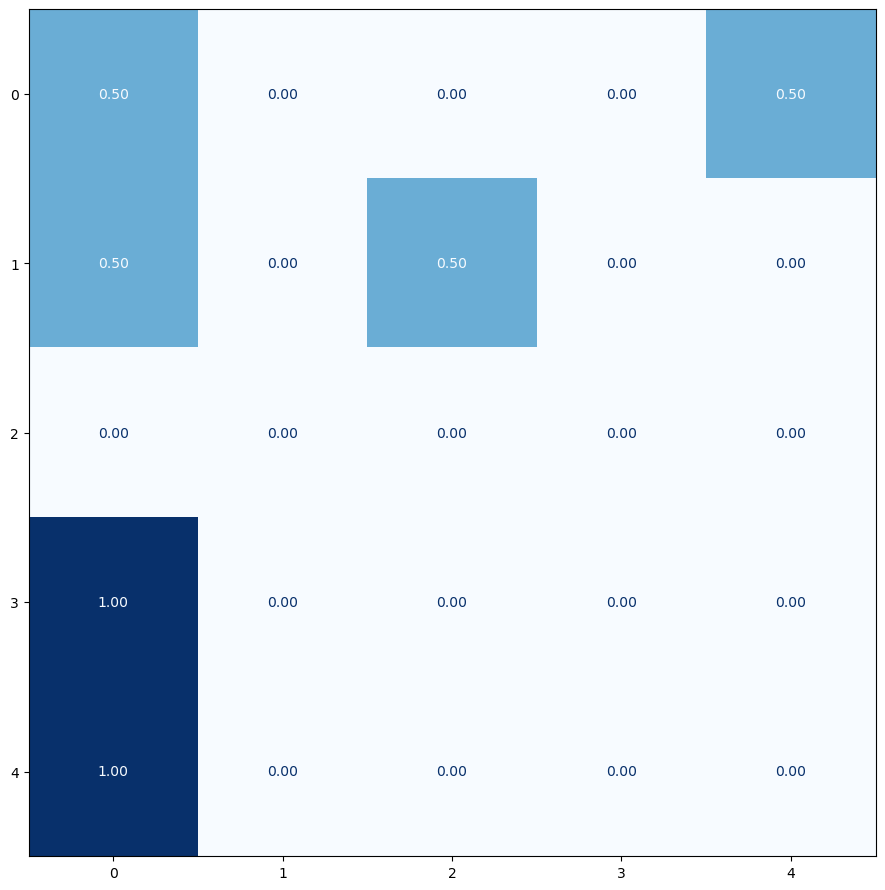

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

#confusion matrix
def plot_confusion_matrix(y_pred, y_true, labels_list):
    cm = confusion_matrix(y_true, y_pred, normalize= "true")
    fig, ax = plt.subplots(figsize=(11,11))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels_list)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar= False)
    plt.title("Normalized confusion Matrix")
    plt.show()

# Confusion Matrix plot
plot_confusion_matrix(y_pred, y_valid, labels_list)

In [33]:
def save_model_pred(df, y_pred, file_name, eval_loss = False):
    # This model save the dataset to csv file
    # this function has been created for save validation dataset
    # with validation prediction extra column
    if (str(type(df)) == "<class 'datasets.arrow_dataset.Dataset'>"):
        df = Dataset.to_pandas(df)
    
    if not(eval_loss == False):
        df["loss"] = eval_loss
        print("enter")

    df["prediction"] = y_pred
    df.to_csv(file_name, index= False)
    print("Dataframe saved to :", file_name)
    return df

def samples_loss(model, prob_predictions, y_test):
    loss_values = []
    for i in range(len(y_test)):
        sample_loss = log_loss([1 if j == y_test[i] else 0 for j in range(model.classes_.size)], prob_predictions[i])
        loss_values.append(sample_loss)
    return loss_values

def df_sample_losses(df):
    df = df[["text", "loss", "prediction", "label"]]
    print("\n Sample with highest losses \n")
    print(df.sort_values("loss", ascending=False).head(10))
    print("\n\n ")

    print("\n Sample with lowest losses \n")
    print(df.sort_values("loss", ascending=True).head(10))
    print("\n\n ")

In [34]:
y_pred_prob = clf.predict_proba(x_valid)
loss_sample = samples_loss(clf, y_pred_prob, y_valid)
loss_df = save_model_pred(valid, y_pred, "model_pred.csv", loss_sample)
df_sample_losses(loss_df) 

enter
Dataframe saved to : model_pred.csv

 Sample with highest losses 

                                                text      loss  prediction  \
6  The appellants further submitted that 'it may ...  1.088190           0   
1  The Victorian Supreme Court dismissed an appea...  0.621858           0   
2  an objection to the production of documents in...  0.577438           0   
7  form of injunctive order is quite specific. It...  0.542851           0   
8  On 7 August 2007 I delivered a judgment (the '...  0.502913           2   
3  the same case, Brennan J (at 84 85) and Dawson...  0.429261           5   
4  Court also has an implied jurisdiction to set ...  0.333033           5   
0  The High Court has ruled that the former manag...  0.284418           0   
5  The decision of the Court of Appeal of Victori...  0.247928           0   

   label  
6      3  
1      5  
2      1  
7      3  
8      1  
3      0  
4      0  
0      0  
5      0  


 

 Sample with lowest losses 

  